# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from noise import pnoise2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.losses import MeanAbsoluteError
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model

The codes between lines is for creating dataset and train it(if you didn't do all that)

----

# Dataset

In [3]:
# Dataset configuration
IMG_SIZE= 256  # Image size
NUM_SAMPLES= 100  # Number of images
SAVE_PATH= "fake_dataset/"

This block for creating the dataset if its not exist yet

In [ ]:
os.makedirs(SAVE_PATH, exist_ok= True)

# Perlin noise generation function for simulating refractory tissue
def generate_perlin_noise(shape, scale= 10):
    noise= np.zeros(shape, dtype= np.float32)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise[i][j]= pnoise2(i / scale, j / scale, octaves= 6, persistence= 0.5, lacunarity= 2.0)
    noise= (noise - noise.min()) / (noise.max() - noise.min())  # Normalization
    return noise

# Creating the fake dataset
for i in range(NUM_SAMPLES):
    texture= generate_perlin_noise((IMG_SIZE, IMG_SIZE), scale= 20)
    thickness_map= np.random.uniform(0.2, 1.0, (IMG_SIZE, IMG_SIZE)) * texture  # Thickness map
    image= (texture * 255).astype(np.uint8)
    mask= (thickness_map * 255).astype(np.uint8)
    
    # Saving image and mask
    cv2.imwrite(f"{SAVE_PATH}/image_{i}.png", image)
    cv2.imwrite(f"{SAVE_PATH}/mask_{i}.png", mask)

Showing some samples

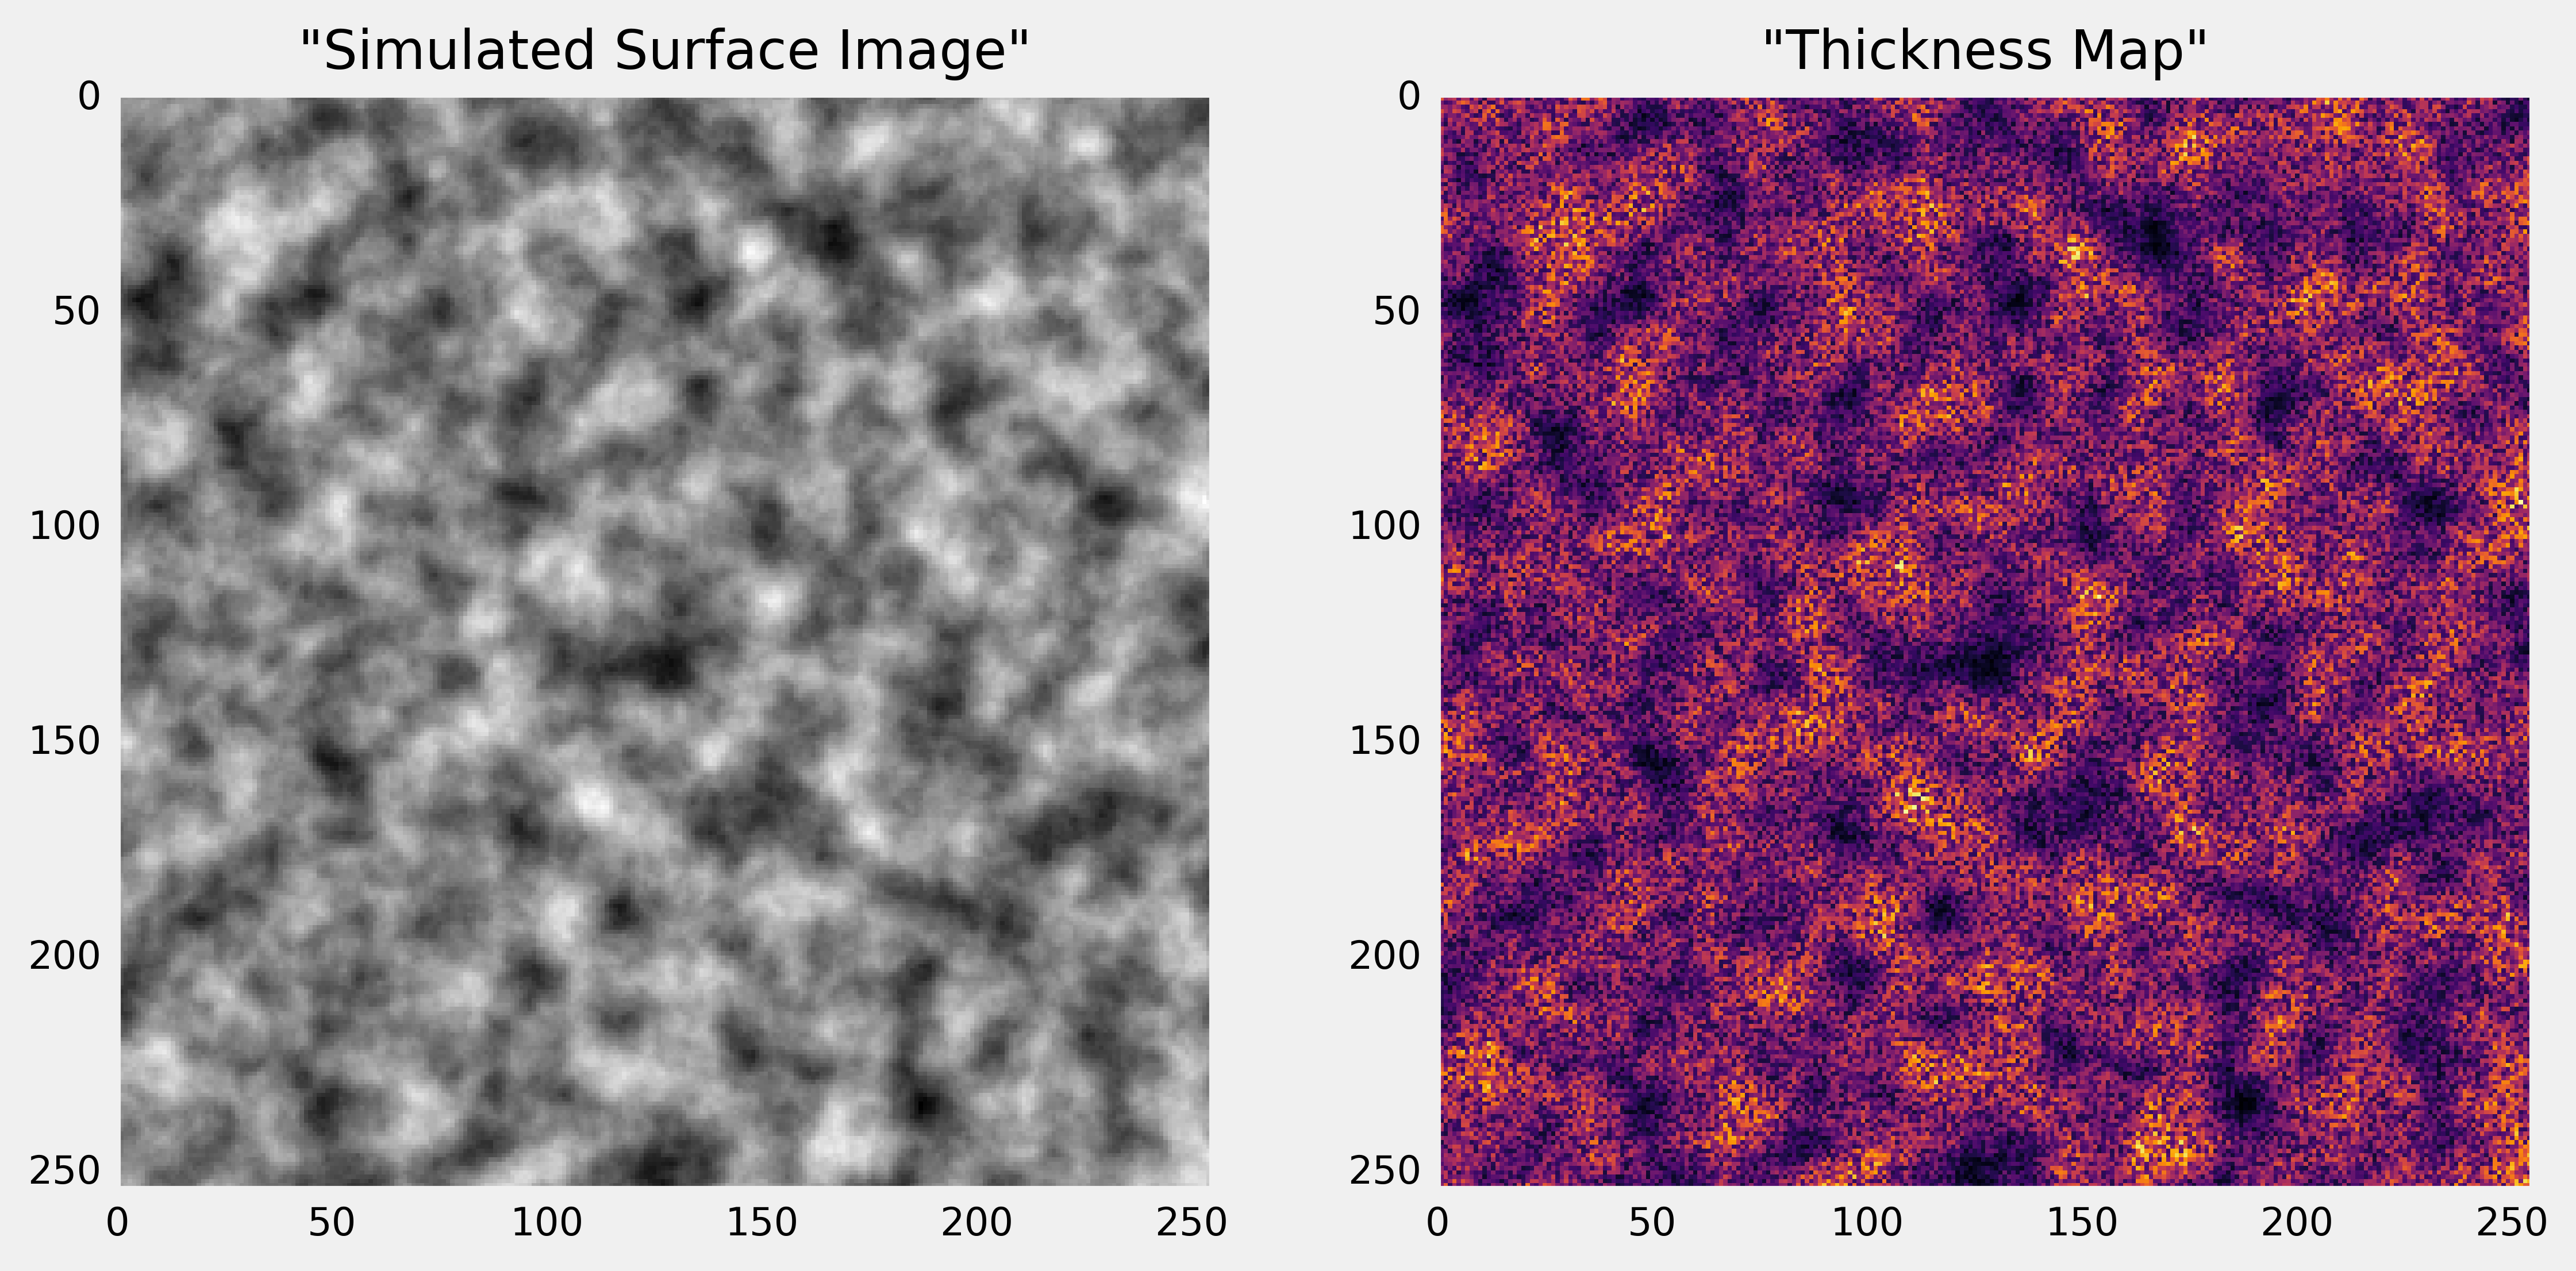

In [3]:
sample_img= cv2.imread(f"{SAVE_PATH}/image_0.png", cv2.IMREAD_GRAYSCALE)
sample_mask= cv2.imread(f"{SAVE_PATH}/mask_0.png", cv2.IMREAD_GRAYSCALE)

plt.style.use('fivethirtyeight')
plt.figure(figsize= (10,5), dpi= 484)
plt.subplot(1,2,1)
plt.title('"Simulated Surface Image"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.imshow(sample_img, cmap= 'gray')
plt.grid(False)
plt.subplot(1,2,2)
plt.title('"Thickness Map"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.imshow(sample_mask, cmap= 'inferno')
plt.grid(False)
plt.show()

# Model

Loading the dataset

In [4]:
DATASET_PATH= "fake_dataset/"
def load_data():
    images, masks= [], []
    for i in range(NUM_SAMPLES):
        img= cv2.imread(f"{DATASET_PATH}/image_{i}.png", cv2.IMREAD_GRAYSCALE)
        mask= cv2.imread(f"{DATASET_PATH}/mask_{i}.png", cv2.IMREAD_GRAYSCALE)
        img= cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalization
        mask= cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        images.append(img)
        masks.append(mask)
    return np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1), np.array(masks).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X, Y= load_data()
print("Dataset Loaded: ", X.shape, Y.shape)

Dataset Loaded:  (100, 256, 256, 1) (100, 256, 256, 1)


Spliting the dataset

In [5]:
X_train, X_temp, Y_train, Y_temp= train_test_split(X, Y, test_size= 0.3, random_state= 48)  # 70% train

# spliting remaining 30% into validation and test (15% each)
X_val, X_test, Y_val, Y_test= train_test_split(X_temp, Y_temp, test_size= 0.5, random_state= 48)  # 15% each

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

Training samples: 70, Validation samples: 15, Test samples: 15


Creating UNet model

In [8]:
def unet():
    inputs= layers.Input((IMG_SIZE, IMG_SIZE, 1))
    # Downsampling
    c1= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(inputs)
    c1= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(c1)
    p1= layers.MaxPooling2D((2,2))(c1)
    
    c2= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(p1)
    c2= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(c2)
    p2= layers.MaxPooling2D((2,2))(c2)
    
    c3= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(p2)
    c3= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(c3)
    p3= layers.MaxPooling2D((2,2))(c3)
    
    # Bottleneck
    c4= layers.Conv2D(512, (3,3), activation= 'relu', padding= 'same')(p3)
    c4= layers.Conv2D(512, (3,3), activation= 'relu', padding= 'same')(c4)
    
    # Upsampling
    u1= layers.UpSampling2D((2,2))(c4)
    u1= layers.concatenate([u1, c3])
    c5= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(u1)
    c5= layers.Conv2D(256, (3,3), activation= 'relu', padding= 'same')(c5)
    
    u2= layers.UpSampling2D((2,2))(c5)
    u2= layers.concatenate([u2, c2])
    c6= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(u2)
    c6= layers.Conv2D(128, (3,3), activation= 'relu', padding= 'same')(c6)
    
    u3= layers.UpSampling2D((2,2))(c6)
    u3= layers.concatenate([u3, c1])
    c7= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(u3)
    c7= layers.Conv2D(64, (3,3), activation= 'relu', padding= 'same')(c7)
    
    outputs= layers.Conv2D(1, (1,1), activation= 'sigmoid')(c7)
    
    model= models.Model(inputs, outputs)
    model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
    return model

model= unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [ ]:
history= model.fit(X_train, Y_train, epochs= 10, batch_size= 5, validation_data= (X_val, Y_val))

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 388s 27s/step - accuracy: 1.6832e-05 - loss: 1.9783 - val_accuracy: 1.9328e-05 - val_loss: 0.6467
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 359s 26s/step - accuracy: 2.2387e-05 - loss: 0.6326 - val_accuracy: 1.9328e-05 - val_loss: 0.6220
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 355s 25s/step - accuracy: 2.1171e-05 - loss: 0.6187 - val_accuracy: 1.9328e-05 - val_loss: 0.6018
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 387s 26s/step - accuracy: 2.1179e-05 - loss: 0.6029 - val_accuracy: 1.9328e-05 - val_loss: 0.6009
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 362s 26s/step - accuracy: 2.1079e-05 - loss: 0.6014 - val_accuracy: 1.9328e-05 - val_loss: 0.6000
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 373s 27s/step - accuracy: 2.2203e-05 - loss: 0.6003 - val_accuracy: 1.9328e-05 - val_loss: 0.5998
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 379s 27s/step - accuracy: 2.3126e-05 - loss: 0.5997 - val_accuracy: 1.9328e-05 - val_loss: 0.5992
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 383s 27s/s

Test

In [ ]:
# Evaluate on test set
test_loss, test_acc= model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 2.3397e-05 - loss: 0.5990
Test Loss: 0.5989540219306946, Test Accuracy: 2.3396809410769492e-05


In [ ]:
sample_idx= np.random.randint(0, NUM_SAMPLES)
prediction= model.predict(X[sample_idx : sample_idx + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


Visualization

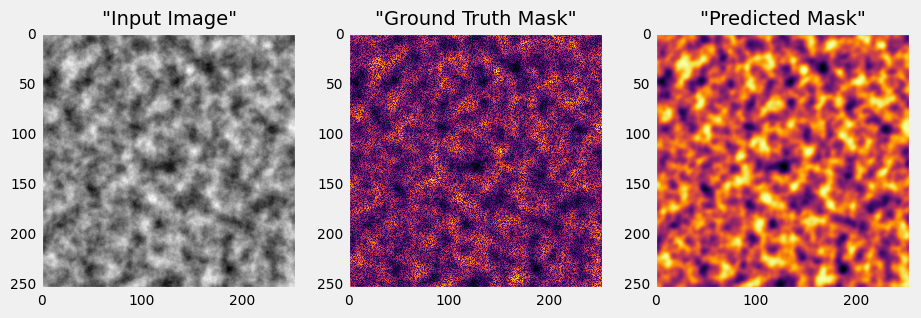

In [ ]:
plt.style.use('fivethirtyeight')

plt.figure(figsize= (10,5))
plt.subplot(1,3,1)
plt.title('"Input Image"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(X[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'gray')

plt.subplot(1,3,2)
plt.title('"Ground Truth Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(Y[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.subplot(1,3,3)
plt.title('"Predicted Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(prediction[0].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.show()

Saving the model

In [ ]:
model.save("thickness_detection_model.h5")

In [ ]:
model.export("thickness_detection_model_tf")

INFO:tensorflow:Assets written to: thickness_detection_model_tf\assets


INFO:tensorflow:Assets written to: thickness_detection_model_tf\assets


Saved artifact at 'thickness_detection_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  2492444112704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442094832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442584064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442586880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442584944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442590048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442584416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442585824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492442585472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2492443658720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  249244366188

----

# Loading the model
(if you already have it)

In [2]:
model= load_model("thickness_detection_model.h5")

Testing the loaded model

In [6]:
sample_idx= np.random.randint(0, NUM_SAMPLES)
prediction= model.predict(X[sample_idx : sample_idx + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


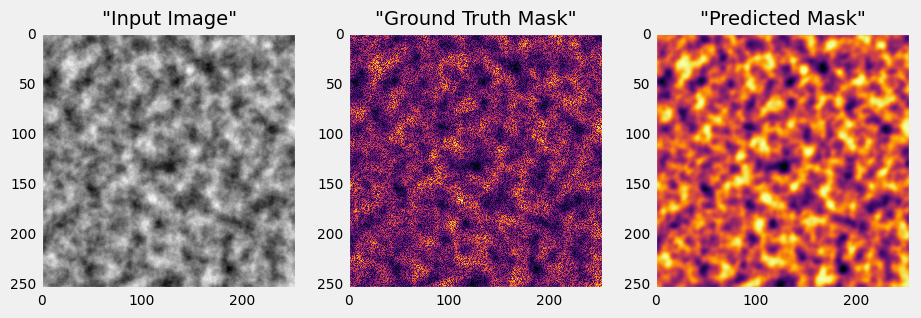

In [7]:
plt.style.use('fivethirtyeight')

plt.figure(figsize= (10,5))
plt.subplot(1,3,1)
plt.title('"Input Image"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(X[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'gray')

plt.subplot(1,3,2)
plt.title('"Ground Truth Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(Y[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.subplot(1,3,3)
plt.title('"Predicted Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(prediction[0].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.show()

# Validation

Mean Absolute Error (MAE)

In [9]:
mae= MeanAbsoluteError()
error= mae(Y_test, model.predict(X_test)).numpy()
print("Mean Absolute Error: ", error)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Mean Absolute Error:  0.10364869


Peak Signal-to-Noise Ratio (PSNR)

In [10]:
def compute_psnr(y_true, y_pred):
    y_true= tf.image.convert_image_dtype(y_true, tf.float32)  # Ensure float32
    y_pred= tf.image.convert_image_dtype(y_pred, tf.float32)  # Ensure float32

    mse= tf.reduce_mean(tf.square(y_true - y_pred))  # Compute Mean Squared Error (MSE)
    psnr= 10.0 * tf.math.log(1.0 / mse) / tf.math.log(10.0)  # Compute PSNR
    return psnr.numpy()

In [11]:
y_pred= model.predict(X_test)

# Ensure same dtype and shape for comparison
y_pred= np.clip(y_pred, 0, 1)  # Ensure valid pixel range
y_true= np.clip(Y_test, 0, 1)  # Ensure valid pixel range

psnr_scores= [compute_psnr(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)]

print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Average PSNR: 18.09 dB


# Spray Amount

In [9]:
sample_idx= np.random.randint(0, NUM_SAMPLES)
predicted_mask= model.predict(X[sample_idx : sample_idx + 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


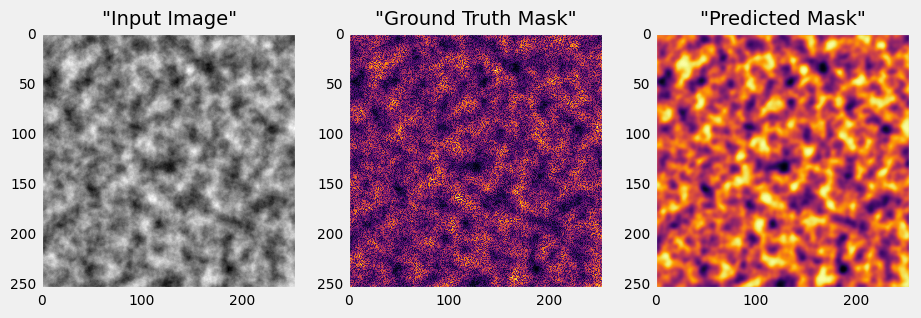

In [10]:
plt.style.use('fivethirtyeight')

plt.figure(figsize= (10,5))
plt.subplot(1,3,1)
plt.title('"Input Image"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(X[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'gray')

plt.subplot(1,3,2)
plt.title('"Ground Truth Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(Y[sample_idx].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.subplot(1,3,3)
plt.title('"Predicted Mask"', fontsize= 14)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
plt.grid(False)
plt.imshow(predicted_mask[0].reshape(IMG_SIZE, IMG_SIZE), cmap= 'inferno')

plt.show()

In [11]:
predicted_mask= np.squeeze(predicted_mask)  # Remove extra dimensions if needed
predicted_mask= (predicted_mask - predicted_mask.min()) / (predicted_mask.max() - predicted_mask.min())  # Normalize

In [12]:
min_spray= 0  # Minimum amount of material (for thick areas)
max_spray= 10  # Maximum amount of material (for thin areas)

spray_amount_map= min_spray + (max_spray - min_spray) * predicted_mask
spray_amount_map

array([[7.206805 , 6.756383 , 6.5653143, ..., 4.6594214, 4.9234066,
        6.1289673],
       [6.7618074, 6.676656 , 6.750535 , ..., 3.2851508, 3.5710323,
        4.90982  ],
       [6.7287674, 6.9114504, 7.0380855, ..., 2.5958905, 2.9111524,
        4.285245 ],
       ...,
       [6.62375  , 6.8714733, 7.135713 , ..., 9.362326 , 8.859703 ,
        8.163842 ],
       [6.8052483, 6.859023 , 7.1244297, ..., 9.009251 , 8.582799 ,
        8.079016 ],
       [7.642479 , 7.4212723, 7.500808 , ..., 8.772306 , 8.539386 ,
        8.417707 ]], dtype=float32)